# OCRD - A 1st Overview 

Here I'll look into the data and train a model following https://towardsdatascience.com/fastai-image-segmentation-eacad8543f6f

## Imports

In [3]:
import hashlib
import imghdr
import os
from pathlib import PosixPath
import re
from tqdm import tqdm_notebook
from zipfile import ZipFile
import xml.etree.ElementTree as ET

from PIL import ImageDraw
from display_xml import XML
from fastai.vision import *
import seaborn as sns
from shapely.geometry import Polygon as ShapelyPolygon

from loguru import logger

!mkdir -p ../input
BAGS = PosixPath(os.path.expanduser('~/Dropbox/0bags'))
INPUT = PosixPath('../input/')

RESIZE_FACTOR = 4  # 1/8th of the original images should be good enough to get a first idea
INPUT_RESIZED = PosixPath(f'../downscale_to_{RESIZE_FACTOR}th')

MASKS = PosixPath('../masks')
MASKS_RESIZED = PosixPath(f'../masks_downscale_to{RESIZE_FACTOR}th')

## Unzip Input data from the (dropbox) folder

In [4]:
zip_archives = BAGS.ls()
print(zip_archives[:5], len(zip_archives))
!du -sh ~/Dropbox/0bags

[PosixPath('/home/janek/Dropbox/0bags/stein_verwaltungslehre07_1868.zip'), PosixPath('/home/janek/Dropbox/0bags/buesch_handlung01_1792.zip'), PosixPath('/home/janek/Dropbox/0bags/brunner_rechtsgeschichte01_1887.zip'), PosixPath('/home/janek/Dropbox/0bags/karsch_gedichte_1792.zip'), PosixPath('/home/janek/Dropbox/0bags/steinen_naturvoelker_1894.zip')] 211
2,9G	/home/janek/Dropbox/0bags


In [5]:
for f in tqdm_notebook(filter(lambda f: f.name.endswith('.zip'), BAGS.ls())):
    dest = INPUT / f.name.replace('.zip', '')
    ZipFile(f, 'r').extractall(dest)

## Give image files a .jpeg or whatever suffix

fastai atm needs it to work correctly (but it's also a nice check of the data integrity, too)

In [6]:
imgfiles = []
imgtypes = set()

for root, dirs, files in os.walk(INPUT):
    path = PosixPath(root)
    if path.name != "OCR-D-IMG": continue
    for imgf in [PosixPath(f) for f in files]:
        if not imgf.suffix:
            imgtype = imghdr.what(path / imgf.name)
            file_with_jpeg_or_whatever = (imgf.name + "." + imgtype)
            os.rename(path / imgf, path / file_with_jpeg_or_whatever)
            imgf = PosixPath(file_with_jpeg_or_whatever)
        imgtypes.add(imgf.suffix)
        imgfiles.append((path / imgf).relative_to(INPUT))
print("Found image files", imgfiles[:5], "...", imgfiles[-5:])
print("Found image types", imgtypes)

Found image files [PosixPath('fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0009.jpeg'), PosixPath('fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0011.jpeg'), PosixPath('fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0014.jpeg'), PosixPath('fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0014.jpeg'), PosixPath('fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0013.jpeg')] ... [PosixPath('mohr_fachwerk02_1875/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg'), PosixPath('gerber_staatsrecht_1865/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg'), PosixPath('gerber_staatsrecht_1865/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg'), PosixPath('dahlmann_politik_1835/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg'), PosixPath('dahlmann_politik_1835/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg')]
Found image types {'.jpeg'}


## Get an overview of original resolutions

In [7]:
image_df = pd.DataFrame({
    "orig": imgfiles, 
    "res": [PIL.Image.open(INPUT / file).size for file in imgfiles],
})
image_df["width"] = image_df.res.apply(lambda t: t[0])
image_df["height"] = image_df.res.apply(lambda t: t[1])
image_df["ratio"] = image_df.height / image_df.width

pd.set_option('max_colwidth', 120)
image_df.head()

orig  \
0  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0009.jpeg   
1  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0011.jpeg   
2  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0014.jpeg   
3  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0014.jpeg   
4  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0013.jpeg   

            res  width  height    ratio  
0  (2724, 3578)   2724    3578  1.31351  
1  (2724, 3578)   2724    3578  1.31351  
2  (2724, 3578)   2724    3578  1.31351  
3  (2724, 3578)   2724    3578  1.31351  
4  (2724, 3578)   2724    3578  1.31351

In [8]:
res_count = image_df.groupby(["width", "height"]).count().sort_values("orig", ascending=False).reset_index()
res_count.head()

width  height  orig  res  ratio
0   2486    3404   118  118    118
1   1560    2241    40   40     40
2   2328    3177    38   38     38
3   1611    2421    38   38     38
4   1563    2304    28   28     28

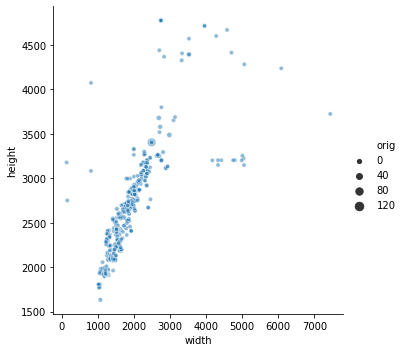

In [9]:
sns.relplot(x="width", y="height", size="orig", data=res_count, alpha=0.5)

## Resize images

In [10]:
PathLike = Union[str, PosixPath]

def pathify(p: PathLike) -> PosixPath:
    return PosixPath(p) if not type(p) is PosixPath else p 

In [11]:
def manipulate_images_(
    orig_folder: PathLike, 
    dest_folder: PathLike, 
    manipulate_: Callable, 
    dest_suffix: str = None,
    overwrite: bool = False
):
    orig_folder = pathify(orig_folder)
    dest_folder = pathify(dest_folder)
    for file in tqdm_notebook(imgfiles):
        if overwrite or not ((dest_folder / file).exists()):
            os.makedirs((dest_folder / file).parent, exist_ok=True)
            dest_path = dest_folder / file
            if dest_suffix: dest_path = dest_path.parent / (dest_path.stem + dest_suffix)
            manipulate_(orig_folder / file, dest_path)

In [12]:
def resize_image_(orig: PosixPath, dest: PosixPath):
    img = open_image(orig)
    img.resize((img.shape[0], img.shape[1] // RESIZE_FACTOR, img.shape[2] // RESIZE_FACTOR))
    img.save(dest)
    
manipulate_images_(INPUT, INPUT_RESIZED, resize_image_)

## Look at segment annotations

In [13]:
def ann_path(img_path: PathLike) -> PosixPath:
    img_path = pathify(img_path)
    page = re.search(r'_(\d+)', img_path.name).group(1)
    p = img_path.parent.parent / "OCR-D-GT-SEG-BLOCK" / f"OCR-D-GT-SEG-BLOCK_{page}"
    if not (INPUT / p).exists():
        logger.warning(f"did not found a file for segmentation path {p} for img {img_path}")
    return p

In [14]:
image_df["ann"] = image_df.orig.apply(ann_path)
image_df.head()

orig  \
0  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0009.jpeg   
1  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0011.jpeg   
2  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0014.jpeg   
3  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0014.jpeg   
4  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0013.jpeg   

            res  width  height    ratio  \
0  (2724, 3578)   2724    3578  1.31351   
1  (2724, 3578)   2724    3578  1.31351   
2  (2724, 3578)   2724    3578  1.31351   
3  (2724, 3578)   2724    3578  1.31351   
4  (2724, 3578)   2724    3578  1.31351   

                                                                                ann  
0  fischer_werkzeugmaschinen01_1900/data/OCR-D-GT-SEG-BLOCK/OCR-D-GT-SEG-BLOCK_0009  
1  fischer_werkzeugmaschinen01_1900/data/OCR-D-GT-SEG-BLOCK/OCR-D-GT-SEG-BLOCK_0011  
2  fischer_werkzeugmaschinen01_1900/data/OCR-D-GT-SEG-BLOCK/OCR-D-GT-SEG-BLOCK_0014  
3  fischer_werkzeugmaschinen01_1900/data/OCR-D-GT-SEG-BLOCK/OCR-D-GT-SEG-BLOCK_0014  
4  fischer_werkzeugmaschinen01_1900/data/OCR-D-GT-SEG-BLOCK/OCR-D-GT-SEG-BLOCK_0013

In [15]:
def ann_xml(p: PathLike) -> str:
    xmlstr = "\n".join(open(INPUT / pathify(p)).readlines())
    xmlstr = re.sub(' xmlns[:\w]*="[^"]+"', '', xmlstr, count=1)  # get rid of the freaking xmlns
    return xmlstr

In [16]:
img_path_example = image_df.orig.values[0]
ann_path_example = image_df.ann.values[0]

Analysiere XML Strukturen, ob die konsistent sind ...

In [17]:
XML(ann_xml(ann_path_example).encode("ascii"))

Looks like we need all the Coords and the parent object contains the segment label Node (+ type if available)

In [18]:
def points2poly(points: str) -> ShapelyPolygon:
    xy_int = [int(p) for p in points.split(" ")]
    return ShapelyPolygon([(x, y) for x, y in zip(xy_int[::2], xy_int[1::2])])

def segments(path: Union[str, PosixPath]) -> List[Dict[str, str]]:
    """ Return dict with pathname, segment label and points 
    
    Arguments:
        path  Can be either image or annotation file path
    """
    
    segs = []
    try:
        xml = ET.fromstring(ann_xml(ann_path(path)))
    except FileNotFoundError as e:
        logger.warning(e)
        return segs
    for segment in xml.findall(".//Coords/.."):
        region_type = segment.attrib.get("type", "")
        if region_type: region_type = "-" + region_type
        label = segment.tag + region_type
        points = segment.find("Coords").attrib["points"]
        points = points.replace(',', ' ')
        segs.append({"path": path, "label": label, "points": points})
        
    for segment in segs:
        poly = points2poly(segment["points"])
        not_a_container = True
        for other_segment in segs:
            if other_segment == segment: continue
            other_poly = points2poly(other_segment["points"])
            if other_poly.within(poly):
                not_a_container = False
                break
        segment["is_node"] = not_a_container

    return segs

Border == Buchseite des Crops

? Warum gibt es mehr Borders als Seiten --> sollten nur <= 1000 sein

### Segmentation data frame

In [19]:
segments_df = pd.concat([pd.DataFrame(segments(f)) for f in imgfiles])
segments_df.head()

path  \
0  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0009.jpeg   
1  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0009.jpeg   
2  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0009.jpeg   
3  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0009.jpeg   
4  fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0009.jpeg   

                    label                                 points  is_node  
0                  Border      13 260 13 3421 2217 3421 2217 260    False  
1       TextRegion-header      526 440 1475 440 1475 535 526 535     True  
2  TextRegion-page-number    1686 450 1775 450 1775 532 1686 532     True  
3           GraphicRegion  306 1253 1740 1253 1740 2205 306 2205     True  
4      TextRegion-caption  890 2203 1082 2203 1082 2253 890 2253     True

In [44]:
import ocrd
orcd.

NameError: name 'orcd' is not defined

* Catch-Word == Soll weg, weil letztes Wort der vorangegangen Seite
* Footnote = alle eine Klasse
* Marginalien aber seperat
* Printspace sind eigentlich (!?) verboten
* Noise-Region wirklich Verschmutzungen (gerne auch im Text(!)): da selten, müssen möglicherweise augmentieren oder oversamplen
* Fünf-Stufige Seperation nur für die Main-Kategorie

In [20]:
segments_df.label.value_counts()

TextRegion-paragraph                    6334
Border                                  2124
TextRegion-page-number                  1702
SeparatorRegion                          990
TextRegion-heading                       798
TextRegion-footnote                      702
TextRegion-header                        664
GraphicRegion                            440
TextRegion-signature-mark                430
TableRegion                              396
TextRegion-caption                       306
TextRegion-catch-word                    270
MathsRegion                              270
TextRegion-footnote-continued            162
GraphicRegion-barcode                    114
TextRegion-marginalia                     76
TextRegion-endnote                        56
GraphicRegion-handwritten-annotation      56
GraphicRegion-stamp                       54
TextRegion-other                          46
NoiseRegion                               42
TextRegion-drop-capital                   26
PrintSpace

Idee: 2-Stufiges Modell auf 1x Text vs alles andere und dann Text ohne den Rest feinklassifizieren

### Segments containing other segments

Will need a domain export on how to proceed with this info
Right now, I'll only process node segmentations.

Fußnoten ebenfalls in ein hierarchiches Modell (seperate Erkennung von Footnotes) und dann den Rest damit nicht mehr belange und dann den Rest damit nicht mehr belangen

Heading = Überschrift irgeneiner Hierrachiestufe

Header = Kopfzeile

Warum enthalten Text-Paragraph andere (leicht überlappende Strukturen, oder schlimmeres?)

In [21]:
pd.crosstab(segments_df.label, segments_df.is_node)

is_node                               False  True 
label                                             
Border                                 2098     26
GraphicRegion                             4    436
GraphicRegion-barcode                     0    114
GraphicRegion-decoration                  0      2
GraphicRegion-handwritten-annotation      0     56
GraphicRegion-other                       0     10
GraphicRegion-stamp                       0     54
MathsRegion                               0    270
NoiseRegion                               0     42
PrintSpace                               12      0
SeparatorRegion                           0    990
TableRegion                               4    392
TextRegion-caption                        0    306
TextRegion-catch-word                     0    270
TextRegion-drop-capital                   0     26
TextRegion-endnote                        2     54
TextRegion-footnote                      42    660
TextRegion-footnote-continued            30    132
TextRegion-header                         0    664
TextRegion-heading                       16    782
TextRegion-marginalia                     0     76
TextRegion-other                         10     36
TextRegion-page-number                    0   1702
TextRegion-paragraph                    130   6204
TextRegion-signature-mark                 0    430

In [22]:
# reserve label 0 for background
classes = {l: c for c, l in enumerate(segments_df.label.unique(), start=1)}  
# Add an extra class to have a separation between segments (as discussed with Uwe)
classes["ArtificialBorder"] = len(classes)
classes["Void"] = 0
classes

{'Border': 1,
 'TextRegion-header': 2,
 'TextRegion-page-number': 3,
 'GraphicRegion': 4,
 'TextRegion-caption': 5,
 'TextRegion-paragraph': 6,
 'MathsRegion': 7,
 'TextRegion-footnote': 8,
 'TextRegion-heading': 9,
 'GraphicRegion-barcode': 10,
 'TableRegion': 11,
 'SeparatorRegion': 12,
 'TextRegion-signature-mark': 13,
 'TextRegion-footnote-continued': 14,
 'TextRegion-catch-word': 15,
 'GraphicRegion-handwritten-annotation': 16,
 'GraphicRegion-stamp': 17,
 'TextRegion-endnote': 18,
 'TextRegion-drop-capital': 19,
 'TextRegion-other': 20,
 'PrintSpace': 21,
 'NoiseRegion': 22,
 'GraphicRegion-other': 23,
 'TextRegion-marginalia': 24,
 'GraphicRegion-decoration': 25,
 'ArtificialBorder': 25,
 'Void': 0}

### Question to the domain experts: What's the difference betweeing a heading and a header?

Also ToDo:
- Check and display all the different Segment types whether they are reasonable with a domain expert
- Check whether they overlap

## Create segmentation mask images

In [23]:
classes

{'Border': 1,
 'TextRegion-header': 2,
 'TextRegion-page-number': 3,
 'GraphicRegion': 4,
 'TextRegion-caption': 5,
 'TextRegion-paragraph': 6,
 'MathsRegion': 7,
 'TextRegion-footnote': 8,
 'TextRegion-heading': 9,
 'GraphicRegion-barcode': 10,
 'TableRegion': 11,
 'SeparatorRegion': 12,
 'TextRegion-signature-mark': 13,
 'TextRegion-footnote-continued': 14,
 'TextRegion-catch-word': 15,
 'GraphicRegion-handwritten-annotation': 16,
 'GraphicRegion-stamp': 17,
 'TextRegion-endnote': 18,
 'TextRegion-drop-capital': 19,
 'TextRegion-other': 20,
 'PrintSpace': 21,
 'NoiseRegion': 22,
 'GraphicRegion-other': 23,
 'TextRegion-marginalia': 24,
 'GraphicRegion-decoration': 25,
 'ArtificialBorder': 25,
 'Void': 0}

In [24]:
np.max(list(PIL.Image.new(mode='L', size=(50, 50), color=0).getdata()))

0

In [25]:
Width = int
Height = int
Resolution = Tuple[Width, Height]
PointsXY = Union[str, List[int]]

def xyfy(p: PointsXY) -> List[int]:
    return [int(xy) for xy in p.split(" ")] if type(p) is str else p

def create_mask_(
    orig_path: PathLike, dest_path: PathLike,
    classes: Dict[str, int], 
    border: str = "ArtificialBorder", border_width: int = 5,  # XXX(js): no idea about a good border_width
    downscale: int = 1,
    only_nodes: bool = True,
):
    dest_path = pathify(dest_path)
    res = PIL.Image.open(orig_path).size
    img = PIL.Image.new(
        mode='L',  # only one 8bit channel (we'll encode the segmentation classes as one-hot)
        size=(res[0] // downscale, res[1] // downscale), 
        color=0
    )
    segs = segments(orig_path)
    if only_nodes: segs = [s for s in segs if s["is_node"]]
    for s in segs:
        s["points"] = [p // downscale for p in xyfy(s["points"])]
        PIL.ImageDraw.Draw(img).polygon(s["points"], fill=classes[s["label"]])
        
    # Also draw artificial borders but after the filled polygon to not get hidden by any overlapping stuff
    for s in segs:
        points = s["points"]
        points += [points[0], points[1]]  # necessary to close the lining (it's not autoclosed like for polygonals)
        PIL.ImageDraw.Draw(img).line(points, fill=classes[border], width=border_width)
    
    assert np.max(list(img.getdata())) <= np.max(list(classes.values()))
    img.save(dest_path)

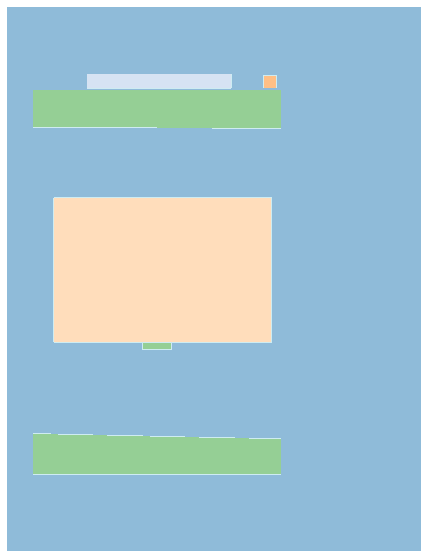

In [26]:
# Note, it's important to save the map as bmp (otherwise jpeg artifacts destroy the mask)
res = image_df.res.values[0]
points = segments(image_df.orig.values[0])[0]["points"]
create_mask_(INPUT / img_path_example, "/tmp/foo.bmp", classes)
seg = open_mask("/tmp/foo.bmp")
seg.show(figsize=(10, 10))

In [27]:
manipulate_images_(
    INPUT, MASKS_RESIZED, 
    partial(create_mask_, classes=classes, downscale=RESIZE_FACTOR, only_nodes=False),
    dest_suffix='.bmp',
    overwrite=True,
)

## Image list

In [28]:
RESNET_SIZE = (224, 224)  # that's what resnet is trained for
print("Normalize all image with resize to", RESNET_SIZE)
def get_y_fn(img_path: PathLike) -> PosixPath:
    img_path = pathify(img_path)
    resized_path = MASKS_RESIZED / img_path.relative_to(INPUT_RESIZED) 
    return resized_path.parent / (resized_path.stem + ".bmp")

def valid_by_book(page: PosixPath, split_pct: float = 0.2) -> bool:
    """ Returns same result for all pages inside a book (given they are in the same folder)"""
    assert type(page) is PosixPath
    h = int(hashlib.md5(str(page.parent).encode("utf-8")).hexdigest(), 16)  # little trick make it stable
    return (h % 1e6) / 1e6 < split_pct

def create_data(
    tfms: List[Transform] = None, 
    bs: int = 4,  # XXX(js): This batch size is a bit too small for batch normalization, but my GTX 1080 can't fit more atm
    sample_p: float = 1.0, split_pct: float = 0.2, split_by_book: bool = False,
    seed: int = None
) -> ImageDataBunch:
    if not tfms: tfms = []
    data= (SegmentationItemList
        .from_folder(INPUT_RESIZED)
        .filter_by_rand(sample_p)
    )
    data = (
        data.split_by_valid_func(valid_by_book)
        if split_by_book
        else data.split_by_rand_pct(valid_pct=split_pct, seed=seed)
    )
    data = (data
        .label_from_func(get_y_fn, classes=classes)
        .transform(tfms, size=RESNET_SIZE, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
    )
    return data

data = create_data(seed=1)
data

Normalize all image with resize to (224, 224)


ImageDataBunch;

Train: LabelList (915 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: ../downscale_to_4th;

Valid: LabelList (228 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: ../downscale_to_4th;

Test: None

In [29]:
data.items

array([PosixPath('../downscale_to_4th/fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0011.jpeg'),
       PosixPath('../downscale_to_4th/fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0014.jpeg'),
       PosixPath('../downscale_to_4th/fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0013.jpeg'),
       PosixPath('../downscale_to_4th/fischer_werkzeugmaschinen01_1900/data/OCR-D-IMG/OCR-D-IMG_0009.jpeg'), ...,
       PosixPath('../downscale_to_4th/mohr_fachwerk02_1875/data/OCR-D-IMG/OCR-D-IMG_0001.jpeg'),
       PosixPath('../downscale_to_4th/mohr_fachwerk02_1875/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg'),
       PosixPath('../downscale_to_4th/gerber_staatsrecht_1865/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg'),
       PosixPath('../downscale_to_4th/dahlmann_politik_1835/data/OCR-D-IMG/OCR-D-IMG_0020.jpeg')], dtype=object)

## Look to some images

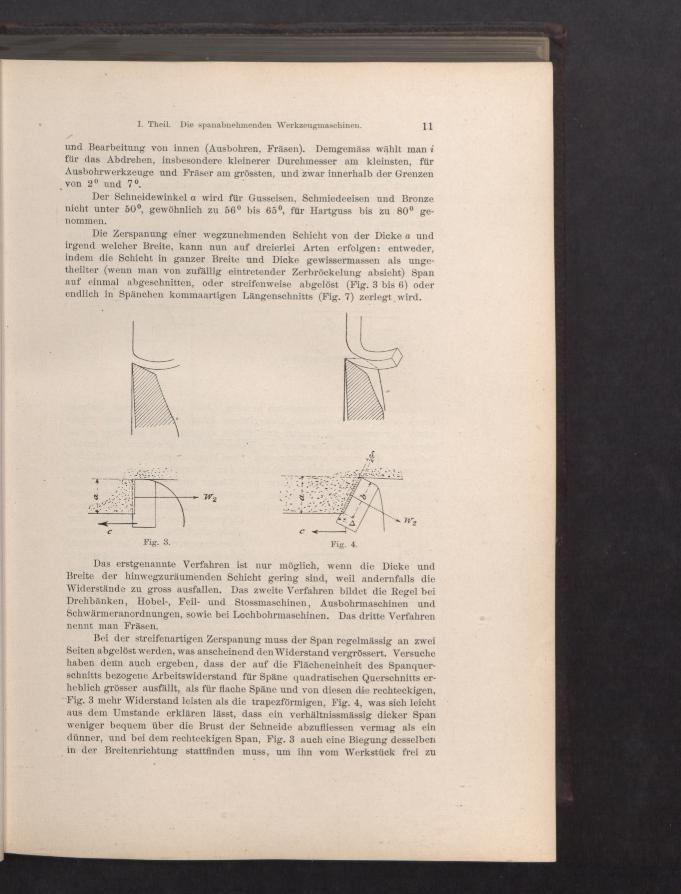

In [30]:
data.x[0]

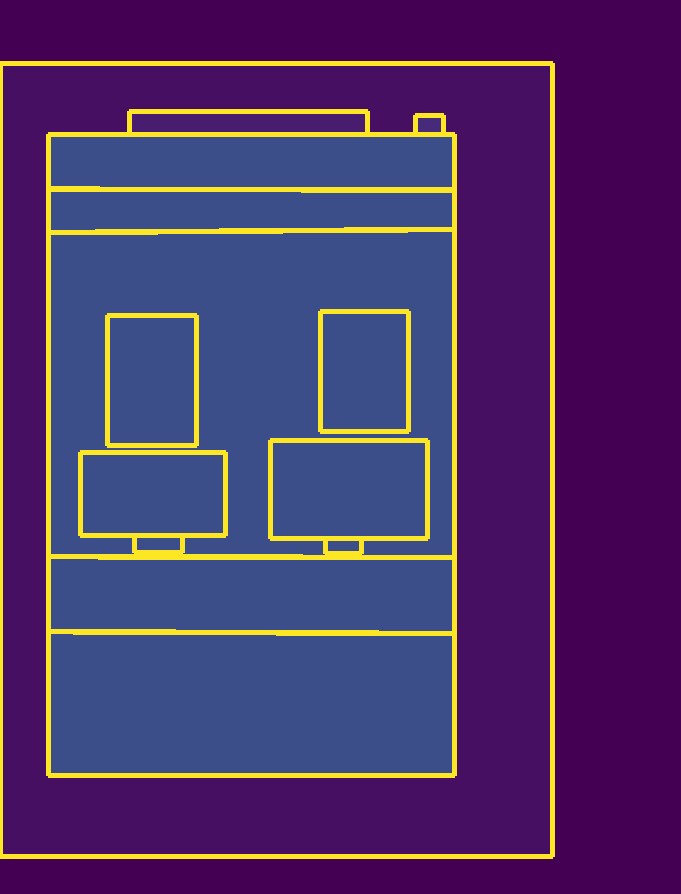

In [31]:
data.y[0]

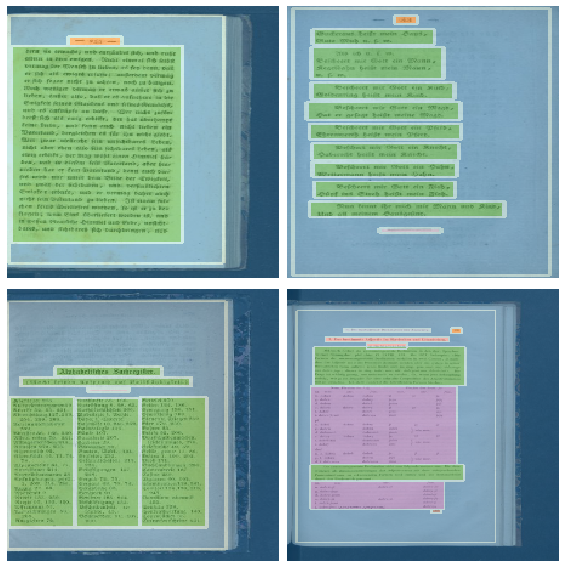

In [33]:
data.show_batch()

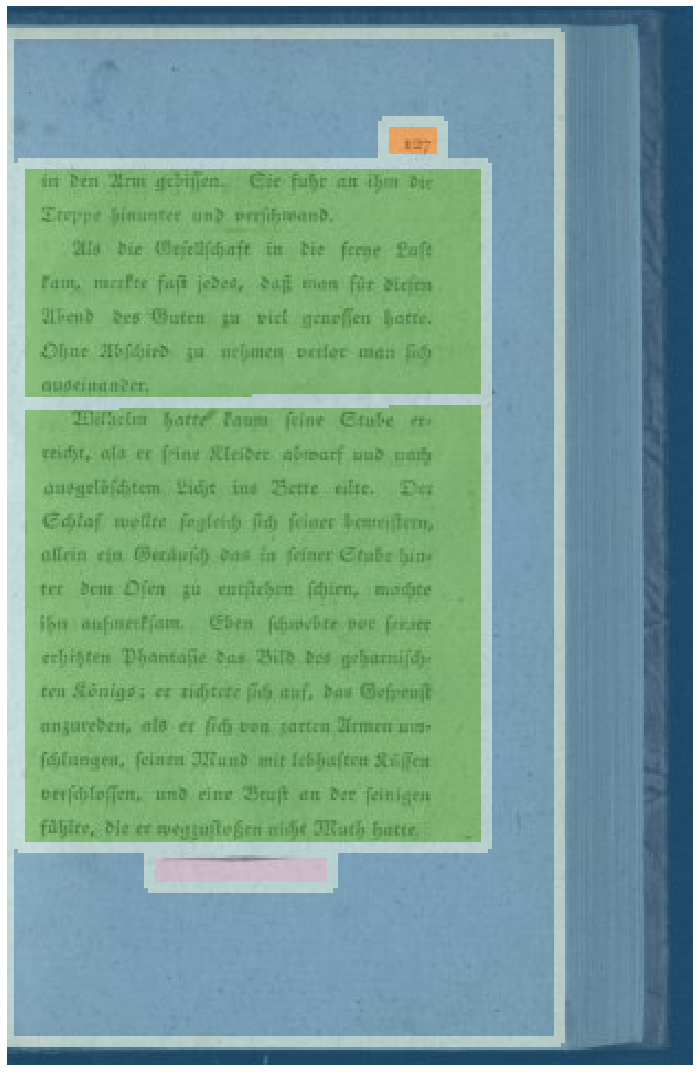

In [35]:
data.show_xys(data.x[99:100], data.y[99:100], figsize=(15, 15))

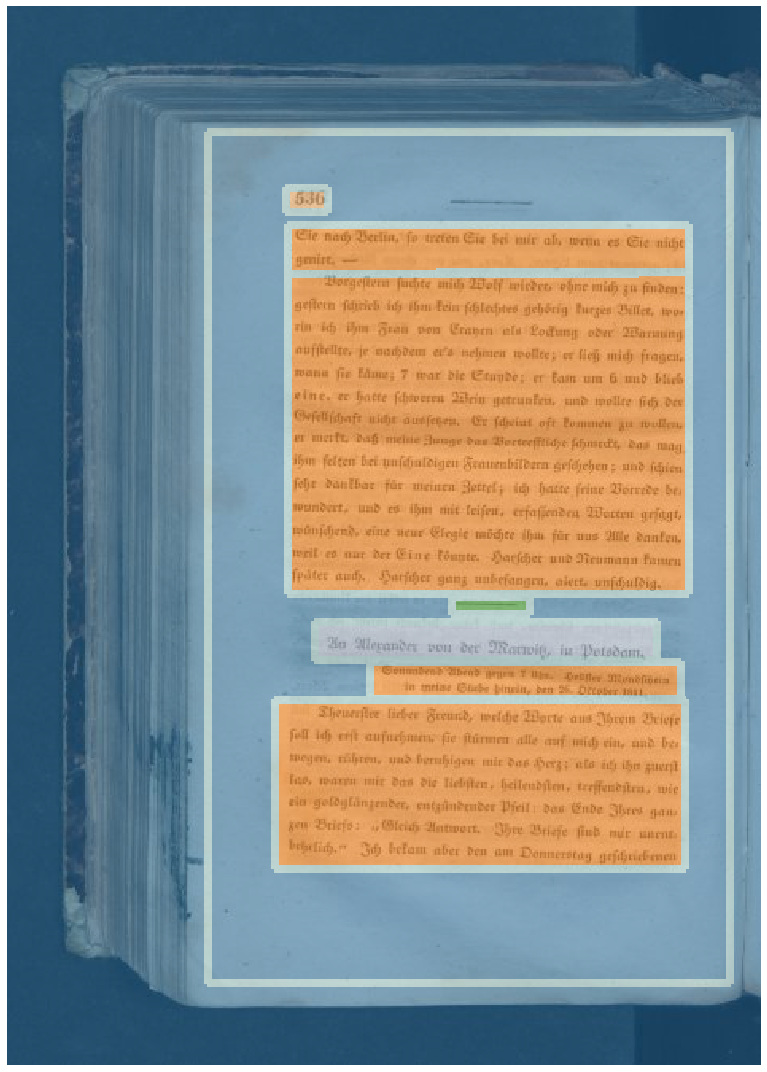

In [36]:
data.show_xys(data.x[1:2], data.y[1:2], figsize=(15, 15))

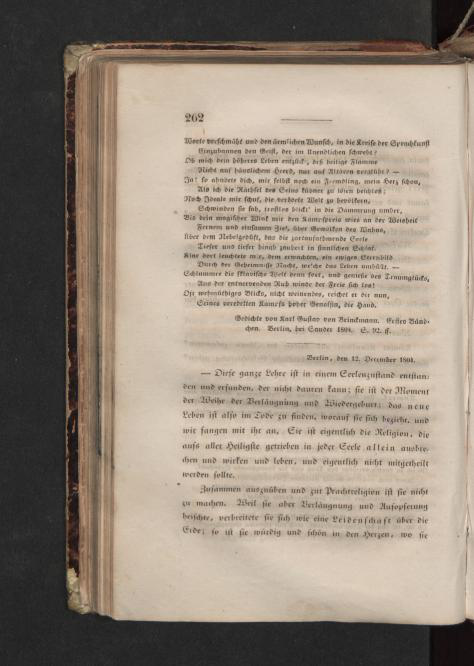

In [37]:
data.x[0]

Maybe not very readable, but should be good enough to try out segmentation. A human would not have a problem here to mark contours of paragraph segments and images or headers (if there were one).

Note to myself: There are some known defects for very small image sizes where models don't work correctly for bigger image sizes. It's an effect known for something like MNIST with 28x28 image sizes (models can't be used for higher resolutions like 200x200 for digit recognition or face detection). I don't think it matters here as the image really is not obfuscated, only the text is a bit blurred. But we don't make text recognition here, so everything should be fine. But we should check it at a later spot in the hackathon.

# Unet Learner Model

## Overfit a tiny sample first

In [38]:
void_code = 0  # I fill image with zeros and we don't want to train this void information
def acc_page_seg(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [39]:
data = None
import gc; gc.collect()
!nvidia-smi

2364

Sun Sep  8 12:40:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
| 29%   42C    P2    37W / 180W |    823MiB /  8111MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [60]:
data = create_data(sample_p=0.05, bs=4)
print(data)
learn = unet_learner(data, models.resnet34, metrics=acc_page_seg)

ImageDataBunch;

Train: LabelList (42 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: ../downscale_to_4th;

Valid: LabelList (10 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: ../downscale_to_4th;

Test: None


In [61]:
learn.fit_one_cycle(20)

In [62]:
learn.unfreeze()
learn.fit_one_cycle(100, max_lr=1e-4)

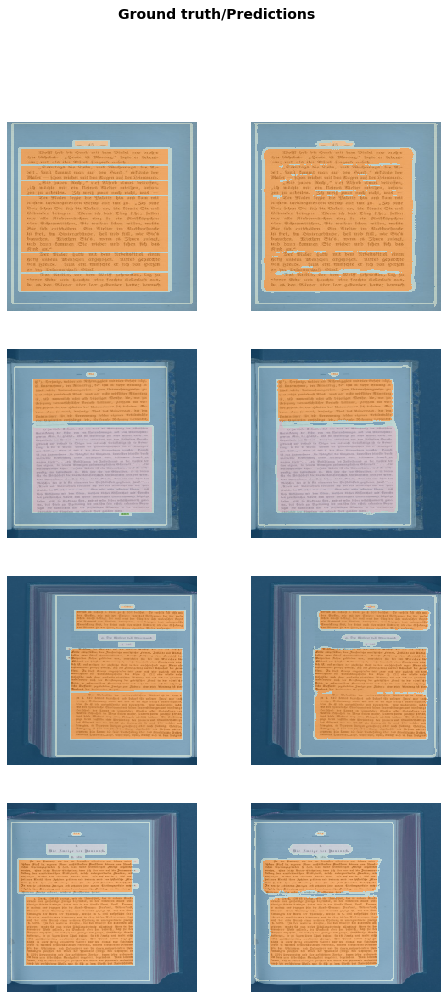

In [63]:
learn.show_results(ds_type=DatasetType.Train)

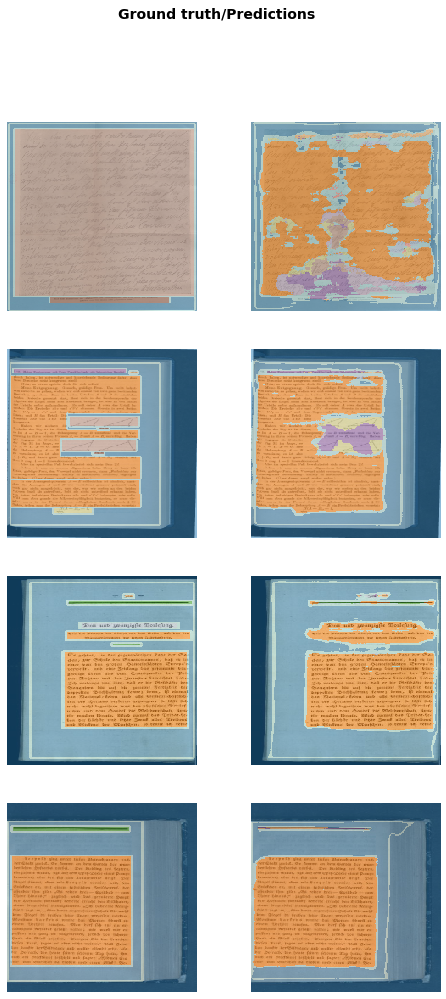

In [64]:
learn.show_results(DatasetType.Valid)

O.K., it does the most important thing right: It learns the training set pretty much perfect,
and even the validation set is okish, given that it was only trained on 42 images, without any regularization (beside batch norm and for a batch size = 4, that's weird also and close to not working), without any augmentation and no early stopping. So, even the drastical overfit validation examples are still ok, I'd say.

In [65]:
learn.save("tiny-unet-v0.1")

## Train on whole dropbox (diverse) dataset of around 1000 images

First a note and reminder on myself. Later, we should not randomly split the data, but make sure that we don't train any page from a book where we run the validation on. (Otherwise there is not so much surprise for the network)

[x] Done

In [70]:
data = None
import gc; gc.collect()
!nvidia-smi

73019

Sun Sep  8 13:26:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
| 27%   35C    P8     7W / 180W |   3005MiB /  8111MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Now also add some transformation

Will start with the default ones

In [36]:
tfms = get_transforms()
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

In [37]:
data = create_data(tfms=tfms, split_by_book=True, seed=42)
data

ImageDataBunch;

Train: LabelList (973 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: ../downscale_to_4th;

Valid: LabelList (170 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: ../downscale_to_4th;

Test: None

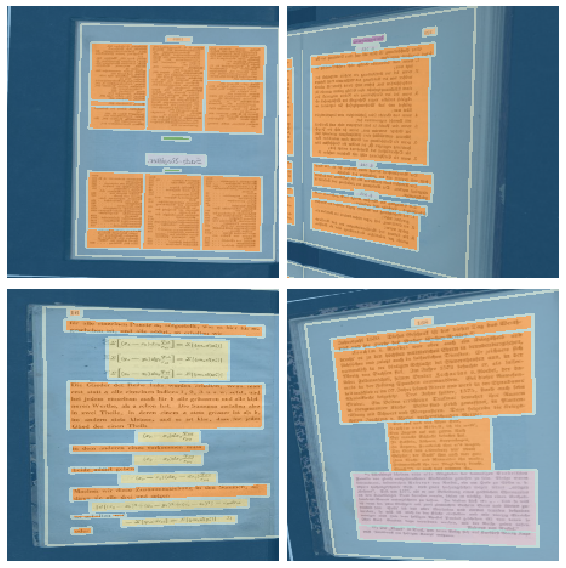

In [94]:
data.show_batch()

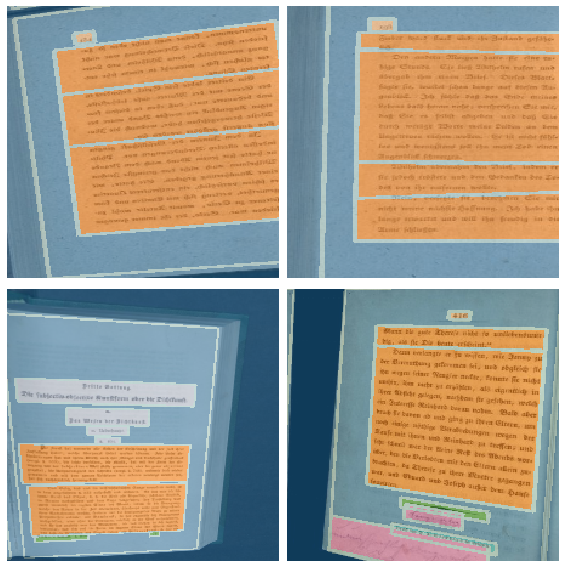

In [95]:
data.show_batch()

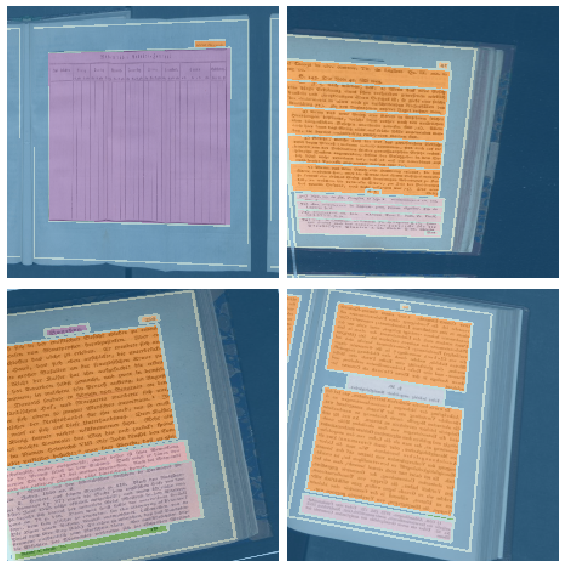

In [96]:
data.show_batch()

Looks dirty enough, doesn't it? Maybe too much? Domain Experts?

### Start with training

In [111]:
learn = unet_learner(data, models.resnet34, metrics=acc_page_seg)

In [112]:
learn.fit_one_cycle(4)

In [113]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(1e-6, 1e-4))

In [114]:
learn.save("unet-diverse-1000-dataset-epochs24")

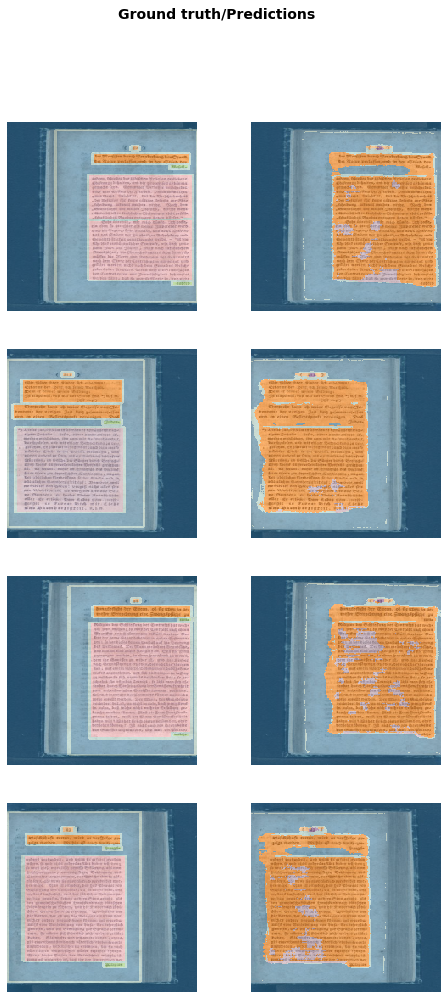

In [115]:
learn.show_results()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


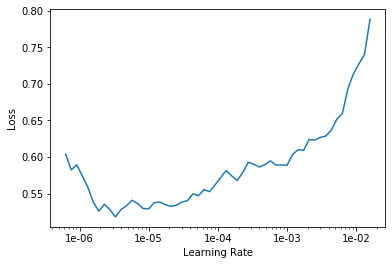

In [116]:
learn.lr_find()
learn.recorder.plot()

In [117]:
learn.fit_one_cycle(25, max_lr=slice(1e-5, 5e-5))

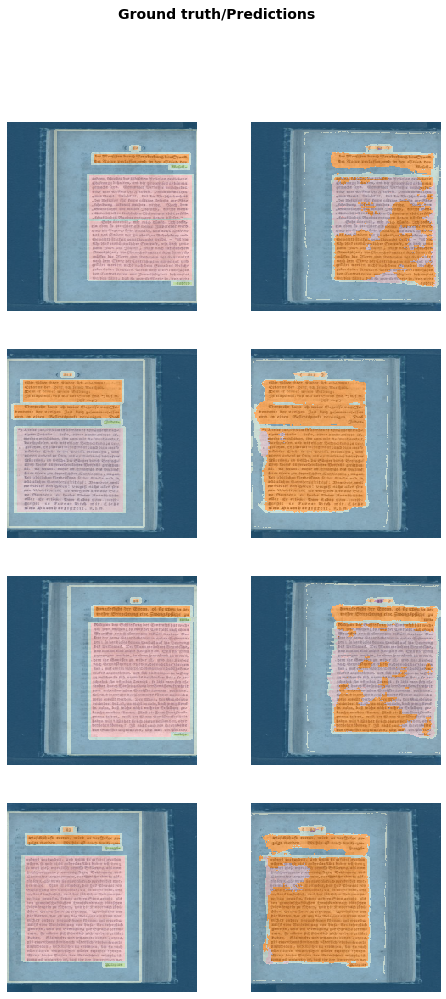

In [118]:
learn.show_results()

In [120]:
learn.save("unet-diverse-1000-dataset-epochs49")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


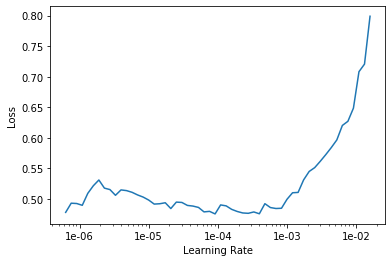

In [119]:
learn.lr_find(start_lr=1e-7)
learn.recorder.plot()

In [121]:
learn.fit_one_cycle(40, max_lr=slice(5e-6, 1e-4))

### Results after ~100 epochs

In [122]:
learn.save("unet-diverse-1000-dataset-epochs89")

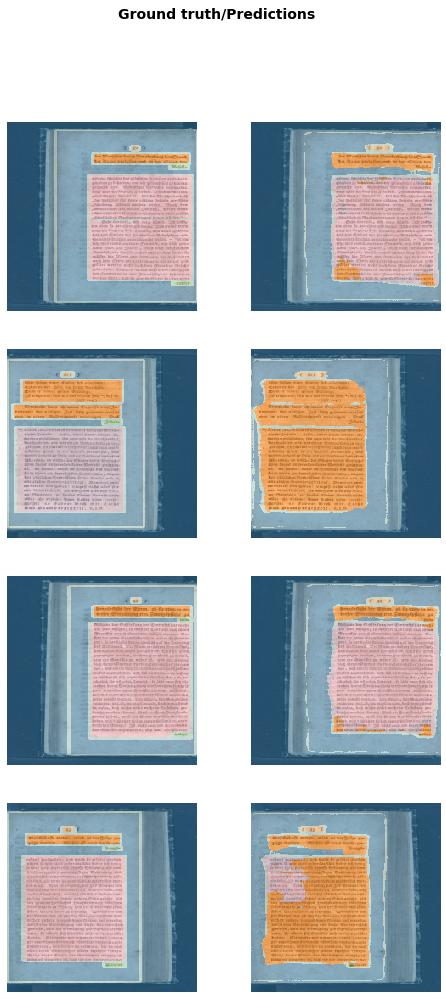

In [123]:
learn.show_results()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


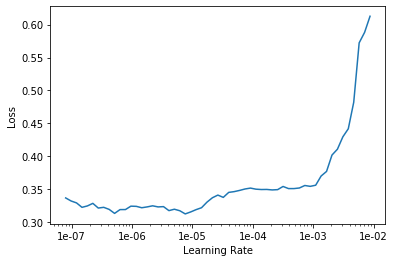

In [125]:
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [128]:
learn.fit_one_cycle(60, max_lr=slice(5e-7, 5e-6))

### Results after ~150 epochs are not better and overfitting might already be in progress start

In [129]:
learn.save("unet-diverse-1000-dataset-epochs149")

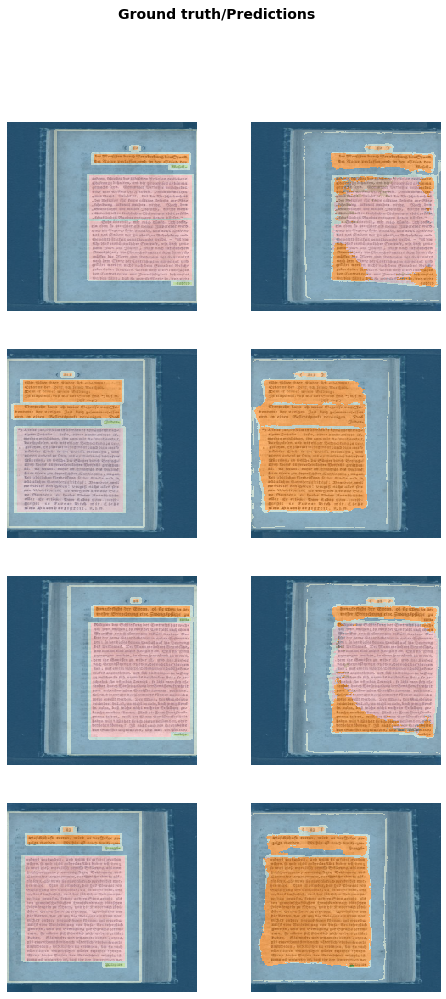

In [130]:
learn.show_results()